In [3]:
import pandas as pd

te = pd.read_csv(
    "Danio_rerio_TE_table.tsv",
    sep="\t"
)

# to drop familes with NA age
# te = te[te["age_Myr"].notna() & (te["age_Myr"] != "NA")]

# clean age to float just in case
te["age_Myr"] = pd.to_numeric(te["age_Myr"], errors="coerce")

# split TE_class into broad type and superfamily
# e.g. "DNA/Harbinger" -> type="DNA", family="Harbinger"
te[["type", "family"]] = te["TE_class"].str.split("/", n=1, expand=True)

# per-chr TE family composition (use bp, not just counts)
te["bp"] = te["length"].astype(int)

per_chr_family = (
    te.groupby(["chrom", "family"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_family.head()

,chrom,family,bp,num_instances
0,NC_007112.7,5s,243397,792
1,NC_007112.7,Academ,7044,49
2,NC_007112.7,CACTA,3167805,19901
3,NC_007112.7,CR1,62333,216
4,NC_007112.7,Copia,379873,1098


In [35]:
type_palette = {
    "DNA":    "#e41a1c",  # red
    "LTR":    "#984ea3",  # purple
    "LINE":   "#377eb8",  # blue
    "SINE":   "#4daf4a",  # green
    "DIRS":   "#a65628",  # brown
    "Other":  "#999999"   # grey
}


In [36]:
dna_family_palette = {
    "hAT":      "#e41a1c",  # red
    "CACTA":    "#ff7f00",  # strong orange
    "TcMar":    "#a65628",  # brown
    "Harbinger":"#f781bf",  # pink
    "Kolobok":  "#fb9a99",  # pale red
    "Helitron": "#fdb462",  # light orange
    "Other":    "#cccccc"
}


In [38]:
# Add family palettes for other TE types
# You can customize these colors as needed

ltr_family_palette = {
    "Gypsy":    "#984ea3",  # purple (base LTR color)
    "Copia":    "#d8b2e8",  # light purple
    "ERV":      "#6a2c70",  # dark purple
    "Other":    "#cccccc"
}

line_family_palette = {
    "L1":       "#377eb8",  # blue (base LINE color)
    "L2":       "#6baed6",  # medium blue
    "CR1":      "#2b5d8a",  # dark blue
    "RTE":      "#9ecae1",  # light blue
    "Other":    "#cccccc"
}

sine_family_palette = {
    "tRNA":     "#4daf4a",  # green (base SINE color)
    "7SL":      "#7fc97f",  # light green
    "5S":       "#2d7a2d",  # dark green
    "Other":    "#cccccc"
}

# Combine all family palettes
family_palette = {}
family_palette.update(dna_family_palette)
family_palette.update(ltr_family_palette)
family_palette.update(line_family_palette)
family_palette.update(sine_family_palette)
family_palette["Other"] = "#cccccc"

# Helper function to get color for any family
def get_family_color(family_name, te_type=None):
    """Get color for a family. Falls back to type color if family not in palette."""
    if family_name in family_palette:
        return family_palette[family_name]
    elif te_type and te_type in type_palette:
        return type_palette[te_type]
    else:
        return type_palette.get("Other", "#999999")

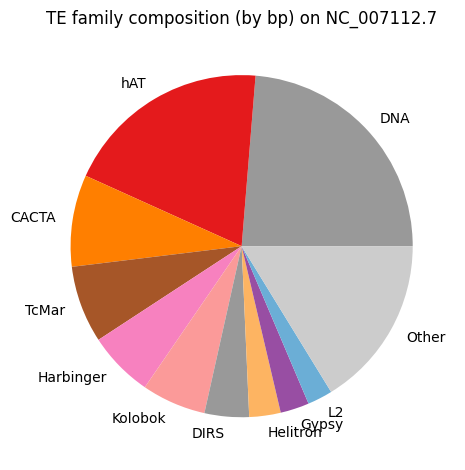

In [39]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("bp", ascending=False).head(N)
others_bp = data_chr["bp"].sum() - top["bp"].sum()

labels = top["family"].tolist()
sizes = top["bp"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

# Apply color palette
colors = [family_palette.get(label, type_palette.get("Other", "#999999")) for label in labels]

plt.figure()
plt.pie(sizes, labels=labels, colors=colors)
plt.title(f"TE family composition (by bp) on {chr_id}")
plt.tight_layout()
plt.show()

In [31]:
# Generate CSV for Canva from the pie chart data
csv_data_pie = {
    "Label": labels,
    "Series 1": sizes
}

pie_df = pd.DataFrame(csv_data_pie)

# Save to CSV
pie_df.to_csv("te_family_pie_chart.csv", index=False)

print("CSV file saved as 'te_family_pie_chart.csv'")
print(f"Shape: {pie_df.shape[0]} rows × {pie_df.shape[1]} columns")
print("\nData:")
pie_df

CSV file saved as 'te_family_pie_chart.csv'
Shape: 7 rows × 2 columns

Data:


,Label,Series 1
0,DNA,141612
1,LTR,9570
2,LINE,6557
3,Unknown,1333
4,SINE,1280
5,unclear,389
6,Unspecified,371


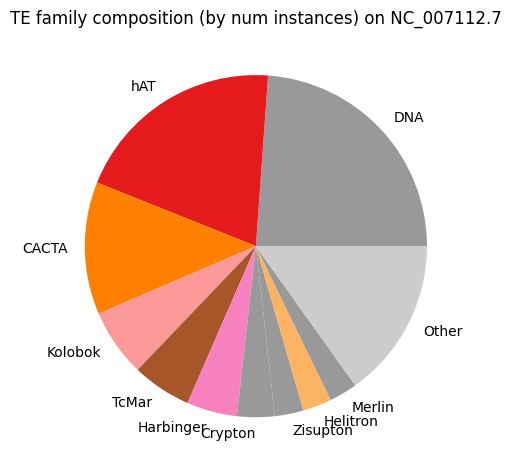

In [40]:
chr_id = "NC_007112.7"
data_chr = per_chr_family[per_chr_family["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_bp = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["family"].tolist()
sizes = top["num_instances"].tolist()

if others_bp > 0:
    labels.append("Other")
    sizes.append(others_bp)

# Apply color palette
colors = [family_palette.get(label, type_palette.get("Other", "#999999")) for label in labels]

plt.figure()
plt.pie(sizes, labels=labels, colors=colors)
plt.title(f"TE family composition (by num instances) on {chr_id}")
plt.tight_layout()
plt.show()

In [54]:
per_chr_type = (
    te.groupby(["chrom", "type"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)

per_chr_type.head()

,chrom,type,bp,num_instances
0,NC_007112.7,DNA,30395015,141612
1,NC_007112.7,LINE,1899797,6557
2,NC_007112.7,LTR,3841666,9570
3,NC_007112.7,SINE,363620,1280
4,NC_007112.7,Unknown,257579,1333


In [48]:
# Check unique chromosome IDs and their sizes
chrom_sizes = te.groupby("chrom")["bp"].sum().sort_values(ascending=False)
print(f"Total sequences: {len(chrom_sizes)}")
print("\nTop 30 sequences by TE content:")
print(chrom_sizes.head(30))

Total sequences: 1919

Top 30 sequences by TE content:
chrom
NC_007115.7       49848522
NC_007118.7       47045764
NC_007116.7       46632064
NC_007114.7       40820815
NC_007113.7       39462935
NC_007117.7       38765825
NC_007112.7       36913823
NC_007131.7       36129548
NC_007127.7       35950240
NC_007120.7       35799778
NC_007119.7       35399148
NC_007125.7       34020238
NC_007128.7       33987221
NC_007129.7       33125065
NC_007124.7       32989873
NC_007123.7       31446302
NC_007126.7       31234689
NC_007130.7       30892613
NC_007134.7       29651947
NC_007132.7       29645013
NC_007121.7       29217222
NC_007122.7       29002169
NC_007135.7       26528375
NC_007133.7       24591353
NC_007136.7       24052531
NW_018394835.1      590299
NW_018394637.1      590160
NW_018394727.1      562293
NW_018395205.1      526838
NW_018395216.1      519315
Name: bp, dtype: int64


In [59]:
# Create mapping from NC_ IDs to chromosome numbers
# Zebrafish chromosomes are NC_007112.7 through NC_007136.7 (chr 1-25)

# Create a dictionary to map NC IDs to chromosome numbers
chrom_mapping = {}

# The NC IDs follow a pattern: NC_007112.7 is chr1, NC_007113.7 is chr2, etc.
for i in range(1, 26):  # chromosomes 1-25
    nc_id = f"NC_00{7111 + i}.7"  # Fixed format with leading zeros
    chrom_mapping[nc_id] = f"Chr{i}"

# Apply the mapping to create a new column with readable chromosome names
te["chr_name"] = te["chrom"].map(chrom_mapping).fillna(te["chrom"])
per_chr_family["chr_name"] = per_chr_family["chrom"].map(chrom_mapping).fillna(per_chr_family["chrom"])

# Recreate per_chr_type with chr_name column included
per_chr_type = (
    te.groupby(["chrom", "type"])
      .agg({"bp": "sum", "TE_name": "count"})
      .rename(columns={"TE_name": "num_instances"})
      .reset_index()
)
per_chr_type["chr_name"] = per_chr_type["chrom"].map(chrom_mapping).fillna(per_chr_type["chrom"])

print("Chromosome mapping created:")
for nc_id, chr_name in sorted(chrom_mapping.items(), key=lambda x: int(x[1].replace("Chr", "")))[:5]:
    print(f"  {nc_id} -> {chr_name}")
print("  ...")
print(f"Total main chromosomes: {len(chrom_mapping)}")

Chromosome mapping created:
  NC_007112.7 -> Chr1
  NC_007113.7 -> Chr2
  NC_007114.7 -> Chr3
  NC_007115.7 -> Chr4
  NC_007116.7 -> Chr5
  ...
Total main chromosomes: 25


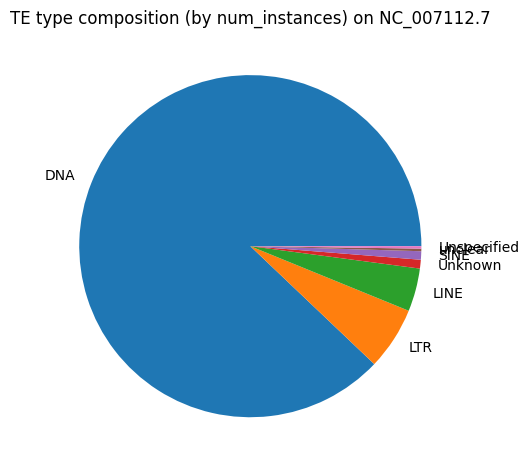

In [14]:
import matplotlib.pyplot as plt

chr_id = "NC_007112.7"
data_chr = per_chr_type[per_chr_type["chrom"] == chr_id]

# Keep only top N families, lump others as "Other"
N = 10
top = data_chr.sort_values("num_instances", ascending=False).head(N)
others_num_instances = data_chr["num_instances"].sum() - top["num_instances"].sum()

labels = top["type"].tolist()
sizes = top["num_instances"].tolist()
if others_num_instances > 0:
    labels.append("Other")
    sizes.append(others_num_instances)

# Apply color palette
colors = [type_palette.get(label, type_palette.get("Other", "#999999")) for label in labels]

plt.figure()
plt.pie(sizes, labels=labels, colors=colors)
plt.title(f"TE type composition (by num_instances) on {chr_id}")
plt.tight_layout()
plt.show()

In [15]:
avg_length_per_type = (
    te.groupby("type")
      .agg({"bp": ["sum", "count", "mean"]})
      .round(0)
)
avg_length_per_type.columns = ["total_bp", "num_instances", "avg_length"]
avg_length_per_type

,total_bp,num_instances,avg_length
type,,,
DNA,879888540,3973363,221.0
LINE,57560120,191253,301.0
LTR,106361578,264214,403.0
SINE,11724422,42593,275.0
Unknown,8665141,37630,230.0
Unspecified,1980150,11166,177.0
unclear,4842485,15064,321.0


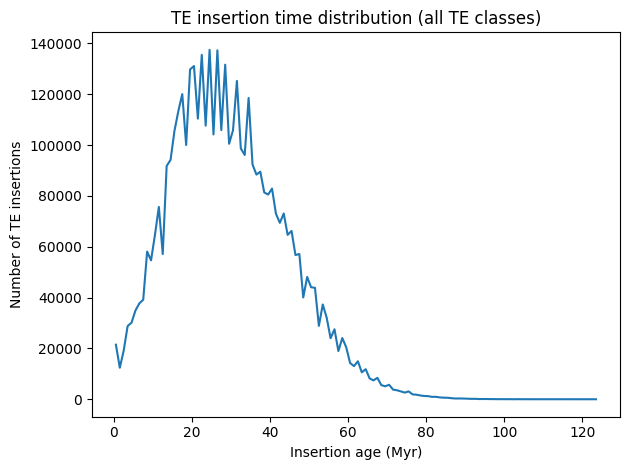

In [16]:
import numpy as np

ages = te["age_Myr"].dropna()

# Choose small bins for high resolution, e.g. 1 Myr
bin_width = 1.0
bins = np.arange(0, ages.max() + bin_width, bin_width)

hist_counts, bin_edges = np.histogram(ages, bins=bins)

# Plot as line (midpoint of each bin vs count)
bin_mid = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure()
plt.plot(bin_mid, hist_counts)
plt.xlabel("Insertion age (Myr)")
plt.ylabel("Number of TE insertions")
plt.title("TE insertion time distribution (all TE classes)")
plt.tight_layout()
plt.show()


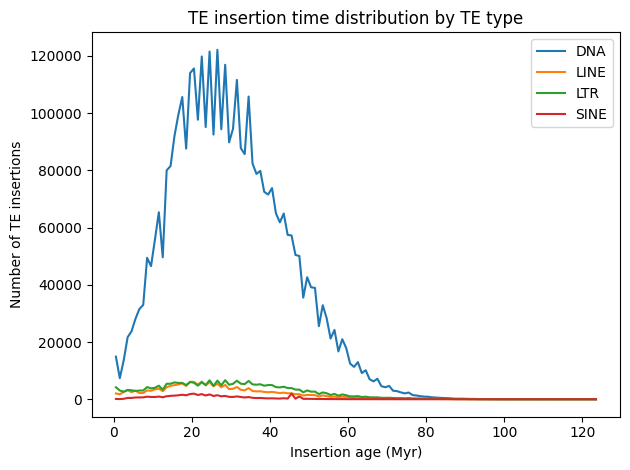

In [17]:
plt.figure()

for t in ["DNA", "LINE", "LTR", "SINE"]:
    sub = te[te["type"] == t]["age_Myr"].dropna()
    if sub.empty:
        continue
    hist_counts, _ = np.histogram(sub, bins=bins)
    # Use type colors
    plt.plot(bin_mid, hist_counts, label=t, color=type_palette.get(t, "#000000"), linewidth=2)

plt.xlabel("Insertion age (Myr)")
plt.ylabel("Number of TE insertions")
plt.title("TE insertion time distribution by TE type")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Generate CSV for Canva
# Create a DataFrame with age bins as rows and TE types as columns

csv_data = {"Label": bin_mid.tolist()}

for t in ["DNA", "LINE", "LTR", "SINE"]:
    sub = te[te["type"] == t]["age_Myr"].dropna()
    if sub.empty:
        csv_data[t] = [0] * len(bin_mid)
    else:
        hist_counts, _ = np.histogram(sub, bins=bins)
        csv_data[t] = hist_counts.tolist()

csv_df = pd.DataFrame(csv_data)

# Round the Label column to 1 decimal place for readability
csv_df["Label"] = csv_df["Label"].round(1)

# Save to CSV
csv_df.to_csv("te_insertion_age_distribution.csv", index=False)

print("CSV file saved as 'te_insertion_age_distribution.csv'")
print(f"Shape: {csv_df.shape[0]} rows × {csv_df.shape[1]} columns")
print("\nFirst few rows:")
csv_df.head(10)

CSV file saved as 'te_insertion_age_distribution.csv'
Shape: 124 rows × 5 columns

First few rows:


,Label,DNA,LINE,LTR,SINE
0,0.5,14887,2023,4186,115
1,1.5,7368,1762,3054,59
2,2.5,13614,2539,2630,164
3,3.5,21662,3170,3257,454
4,4.5,23753,2479,3129,466
5,5.5,28057,2998,2911,605
6,6.5,31508,2179,3043,639
7,7.5,32986,2190,3060,661
8,8.5,49430,3079,4258,906
9,9.5,46532,2967,3794,803


In [28]:
import matplotlib.pyplot as plt

def plot_te_family_pie(per_chr_family, chr_id, top_n=8, min_frac=0.02):
    df = per_chr_family[per_chr_family["chrom"] == chr_id].copy()
    total_bp = df["bp"].sum()
    df["frac"] = df["bp"] / total_bp

    # Sort by bp
    df = df.sort_values("bp", ascending=False)

    # Take top_n or families above min_frac, whichever is stricter
    main = df.head(top_n)
    main = main[main["frac"] >= min_frac]
    other_bp = total_bp - main["bp"].sum()

    labels = main["family"].tolist()
    sizes = main["bp"].tolist()

    if other_bp > 0:
        labels.append("Other")
        sizes.append(other_bp)

    # Apply color palette
    colors = [family_palette.get(label, type_palette.get("Other", "#999999")) for label in labels]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90
    )
    ax.set_title(f"TE family composition (by bp) on {chr_id}")

    plt.tight_layout()
    plt.show()

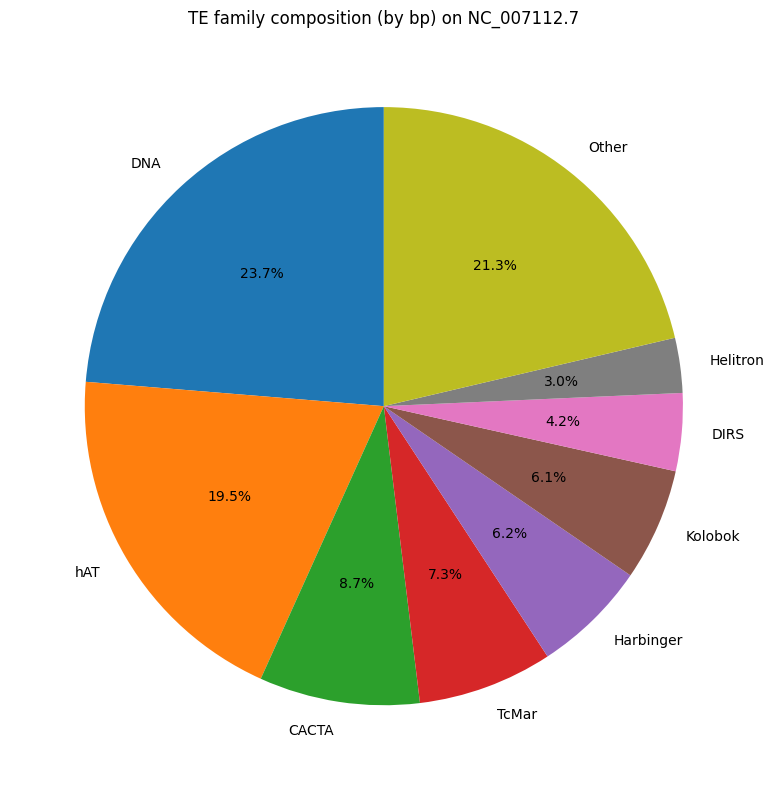

In [29]:
plot_te_family_pie(per_chr_family, "NC_007112.7")


In [20]:
def plot_te_family_bar(per_chr_family, chr_id, top_n=15):
    df = per_chr_family[per_chr_family["chrom"] == chr_id].copy()
    total_bp = df["bp"].sum()
    df["frac"] = df["bp"] / total_bp

    df = df.sort_values("bp", ascending=False).head(top_n)

    # Apply color palette
    colors = [family_palette.get(fam, type_palette.get("Other", "#999999")) for fam in df["family"]]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.barh(df["family"], df["frac"], color=colors)
    ax.set_xlabel("Fraction of chromosome covered by family")
    ax.set_ylabel("TE family")
    ax.set_title(f"Top {top_n} TE families on {chr_id}")
    ax.invert_yaxis()  # biggest at top
    plt.tight_layout()
    plt.show()

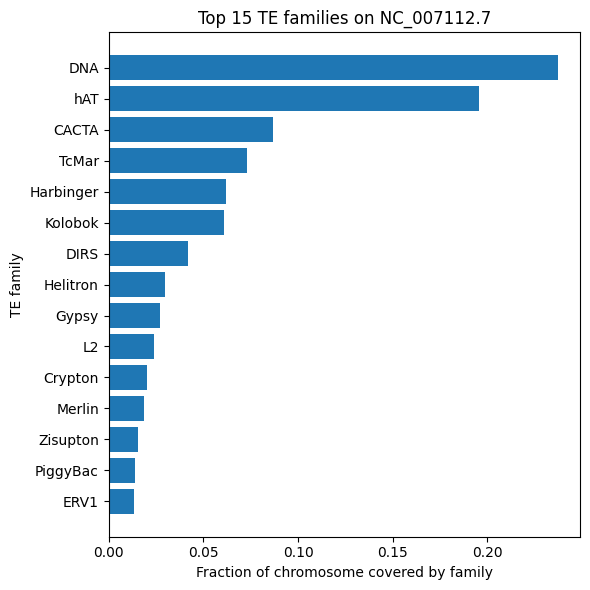

In [21]:
plot_te_family_bar(per_chr_family, "NC_007112.7")


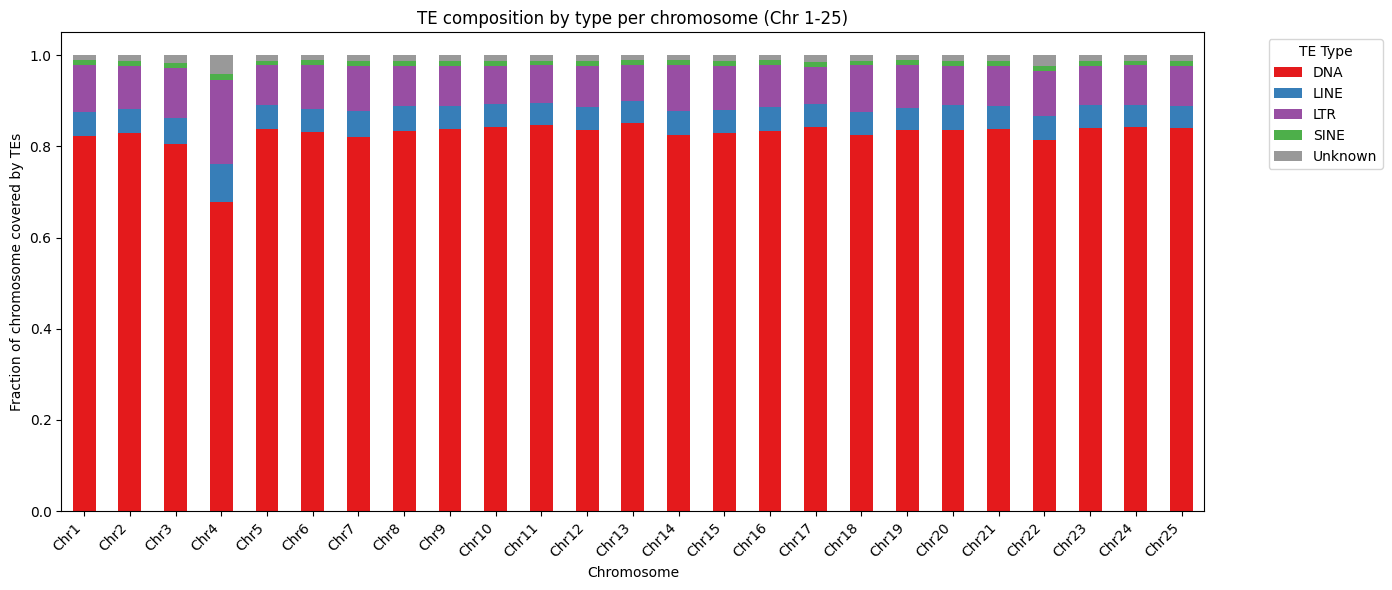

Showing 25 chromosomes: Chr1, Chr2, Chr3, Chr4, Chr5, Chr6, Chr7, Chr8, Chr9, Chr10, Chr11, Chr12, Chr13, Chr14, Chr15, Chr16, Chr17, Chr18, Chr19, Chr20, Chr21, Chr22, Chr23, Chr24, Chr25


In [61]:
# Stacked bar chart showing TE type composition across main chromosomes
# Filter to show only chromosomes 1-25 (exclude scaffolds)

# First, consolidate Unknown/Unspecified/unclear into a single "Unknown" category
per_chr_type_clean = per_chr_type.copy()
per_chr_type_clean['type'] = per_chr_type_clean['type'].replace({
    'Unspecified': 'Unknown',
    'unclear': 'Unknown'
})

# Reaggregate after combining categories
per_chr_type_clean = (
    per_chr_type_clean.groupby(['chrom', 'type', 'chr_name'])
    .agg({'bp': 'sum', 'num_instances': 'sum'})
    .reset_index()
)

table = per_chr_type_clean.pivot(index="chr_name", columns="type", values="bp").fillna(0)

# Filter to keep only main chromosomes (Chr1-Chr25)
main_chroms = [f"Chr{i}" for i in range(1, 26)]
main_chroms_present = [c for c in main_chroms if c in table.index]
table_main = table.loc[main_chroms_present]

# Sort by chromosome number
table_main = table_main.reindex(sorted(table_main.index, key=lambda x: int(x.replace("Chr", ""))))

# Calculate fractions
table_frac = table_main.div(table_main.sum(axis=1), axis=0)

# Make figure larger and rotate labels for readability
fig, ax = plt.subplots(figsize=(14, 6))
table_frac.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=[type_palette.get(t, "#999999") for t in table_frac.columns]
)
ax.set_ylabel("Fraction of chromosome covered by TEs")
ax.set_xlabel("Chromosome")
ax.set_title("TE composition by type per chromosome (Chr 1-25)")
ax.legend(title="TE Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Showing {len(table_main)} chromosomes: {', '.join(table_main.index.tolist())}")

In [62]:
# Generate CSV for Canva from the stacked bar chart
# Transpose so chromosomes are rows and TE types are columns

csv_data_stacked = {"Chromosome": table_frac.index.tolist()}

for te_type in table_frac.columns:
    csv_data_stacked[te_type] = table_frac[te_type].tolist()

stacked_df = pd.DataFrame(csv_data_stacked)

# Save to CSV
stacked_df.to_csv("te_chromosome_composition.csv", index=False)

print("CSV file saved as 'te_chromosome_composition.csv'")
print(f"Shape: {stacked_df.shape[0]} rows × {stacked_df.shape[1]} columns")
print("\nFirst few rows:")
stacked_df.head(10)

CSV file saved as 'te_chromosome_composition.csv'
Shape: 25 rows × 6 columns

First few rows:


,Chromosome,DNA,LINE,LTR,SINE,Unknown
0,Chr1,0.823405,0.051466,0.104071,0.009851,0.011208
1,Chr2,0.829046,0.052920,0.094631,0.010950,0.012453
2,Chr3,0.805433,0.055701,0.110892,0.011179,0.016795
3,Chr4,0.678103,0.082394,0.184584,0.013729,0.041189
4,Chr5,0.837822,0.051889,0.087831,0.010372,0.012087
5,Chr6,0.831583,0.049625,0.096849,0.010805,0.011139
6,Chr7,0.820478,0.057636,0.097628,0.011530,0.012727
7,Chr8,0.832633,0.056344,0.087170,0.011298,0.012555
8,Chr9,0.837358,0.051003,0.087725,0.011385,0.012530
9,Chr10,0.841443,0.051682,0.083672,0.011145,0.012059
